In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autograd
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
import math

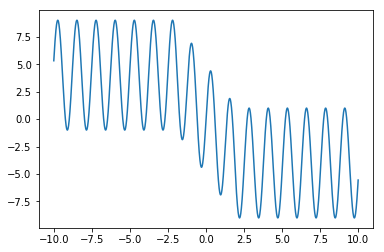

In [2]:
#построение графика функции
func = lambda x: abs(x-2) - abs(x+2) + 5*np.sin(5*x)
# dx Шаг между точками
dx = 0.01
xlist = np.arange(start = -10, stop = 10, step = dx)
ylist = [func(x) for x in xlist]
plt.plot(xlist, ylist)
plt.savefig('ini_func.png', bbox_inches='tight')

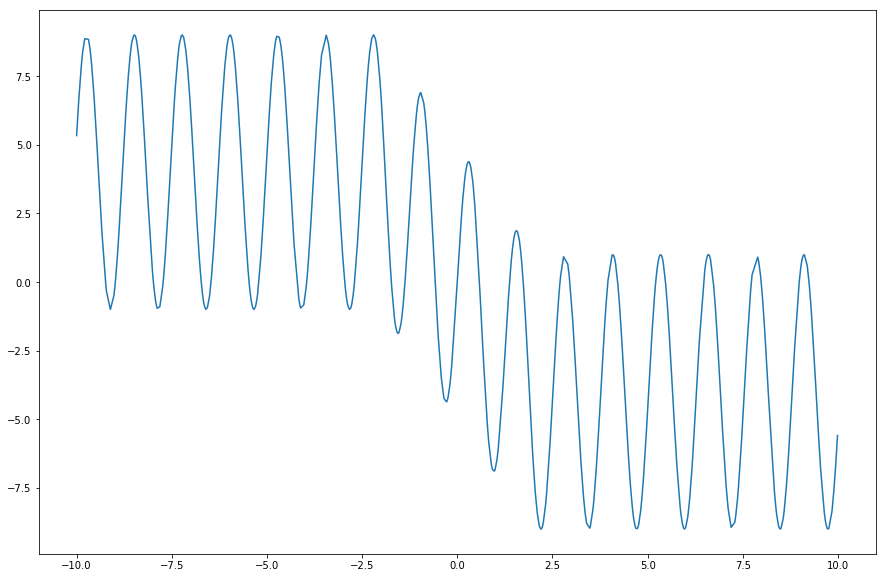

In [3]:
#Формирование исходных данных
#рандомно выберем точки на оси Х
X_data = 20 * (np.random.random(800) - 0.5)
X_data.sort()
Y_data = [func(x) for x in X_data]
data = np.array(list(zip(X_data, Y_data)))

plt.figure(figsize=(15,10))
plt.plot(data[:, 0], data[:, 1])

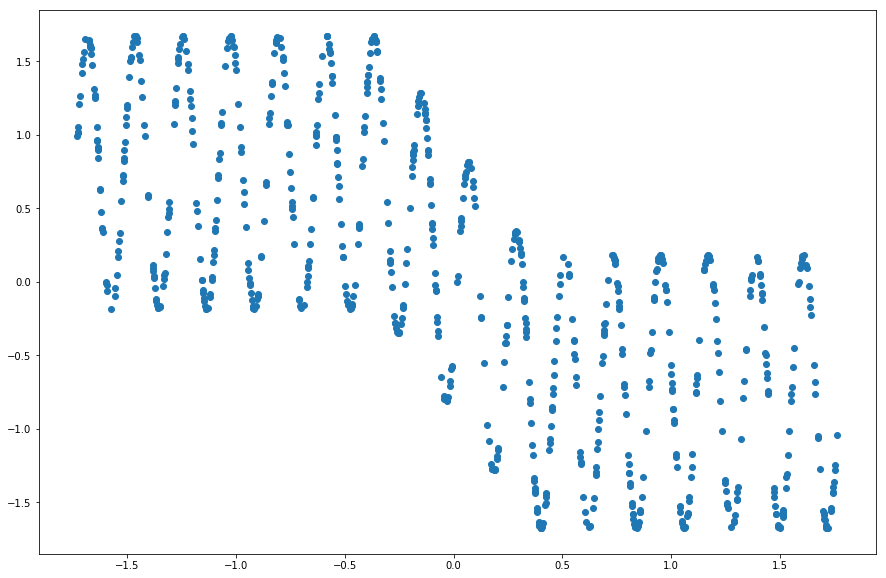

In [4]:
# Преобразование данных
scaler = preprocessing.StandardScaler(copy=False)
scaler.fit_transform(data)
plt.figure(figsize=(15,10))
plt.scatter(data[:, 0], data[:, 1])

In [5]:
#премешать
np.random.shuffle(data)
print(data[:5])

[[-1.61485727  0.35596289]
 [-0.81515049  1.64424907]
 [ 1.51395865 -1.58615545]
 [-0.5597249   1.400721  ]
 [ 1.43406169 -0.50235499]]



 480 240 80


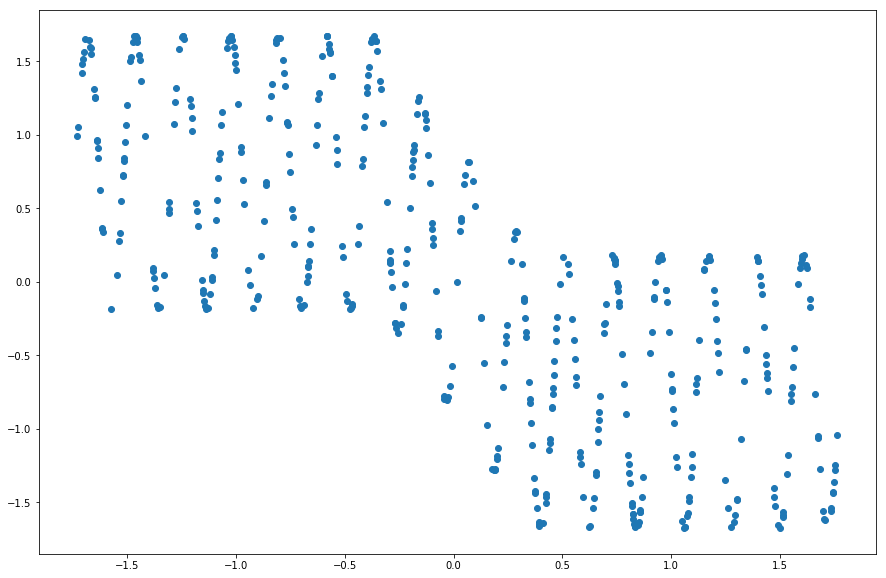

In [6]:
#отметим границы
train_border = [0, int(len(data)*0.6)]
valid_border = [int(len(data)*0.6), int(len(data)*0.9)]
test_border = [int(len(data)*0.9), len(data)]

#делим 
learn_data = data[train_border[0]: train_border[1]]
valid_data = data[valid_border[0]: valid_border[1]]
test_data = data[test_border[0]: test_border[1]]

print('\n', len(learn_data), len(valid_data), len(test_data))
plt.figure(figsize=(15, 10))
plt.scatter(learn_data[:, 0], learn_data[:, 1])


In [7]:
class SinDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [8]:
dataset = SinDataset(learn_data)
dataloader = DataLoader(dataset, batch_size=50, shuffle=False)

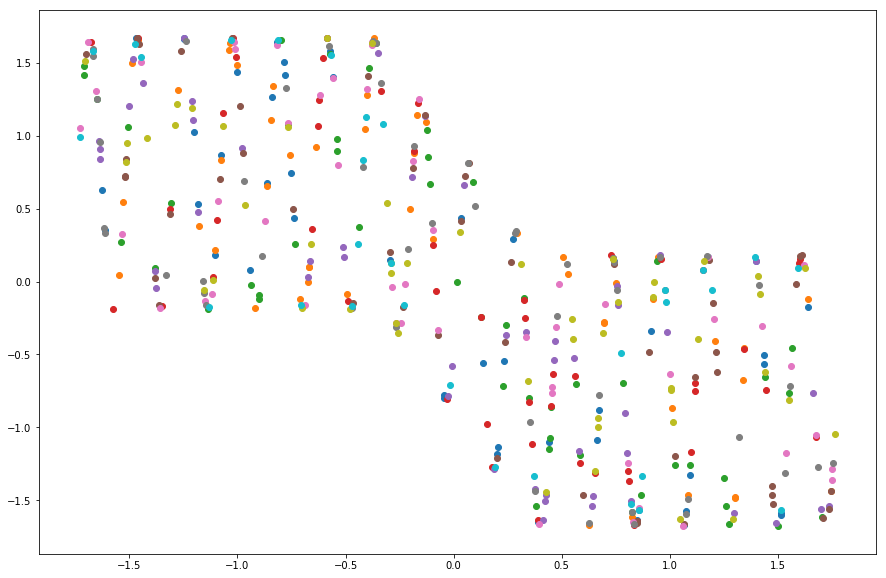

In [9]:
plt.figure(figsize=(15, 10))
for i in dataloader:
    plt.scatter(i[:, 0], i[:, 1])

In [10]:
class MainNet(nn.Module):
    def __init__(self):
        super(MainNet, self).__init__()
        self.lin1 = nn.Linear(1, 30)
        self.lin2 = nn.Linear(30, 1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.tanh(x)
        x = self.lin2(x)
        return x

In [11]:
net = MainNet()
net

MainNet(
  (lin1): Linear(in_features=1, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=1, bias=True)
)

In [12]:
print(type(net.lin1.weight))
net.lin1.weight.data.t()

<class 'torch.nn.parameter.Parameter'>


tensor([[-0.4791, -0.2253, -0.2406, -0.8260,  0.3779, -0.8484,  0.7589,
         -0.7673, -0.3558,  0.4806,  0.5582,  0.8380, -0.9619,  0.9683,
          0.0881,  0.8625, -0.7265, -0.8264, -0.2655, -0.0676, -0.3011,
          0.8883, -0.2776,  0.6405, -0.8775, -0.9052, -0.6272, -0.2983,
          0.0900,  0.4069]])

In [13]:
stds = [math.sqrt(2/32), math.sqrt(2/32)]
stds.reverse()
def init_weights(layer):
    if (type(layer) == nn.Linear):
        layer.weight.data = torch.randn(layer.weight.data.shape)*stds.pop()
        
net.apply(init_weights)

MainNet(
  (lin1): Linear(in_features=1, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=1, bias=True)
)

In [14]:
print(type(net.lin1.weight))
net.lin1.weight.data.t()

<class 'torch.nn.parameter.Parameter'>


tensor([[ 0.0232, -0.0432, -0.1124, -0.4524, -0.0809, -0.0349,  0.3371,
          0.0710, -0.5884,  0.7352, -0.0777,  0.6013, -0.4814, -0.1200,
          0.0193,  0.3263, -0.1383, -0.2629, -0.2064,  0.2572,  0.2788,
         -0.1538, -0.1517, -0.3572,  0.1292,  0.0993, -0.0612,  0.1196,
          0.3455, -0.0129]])

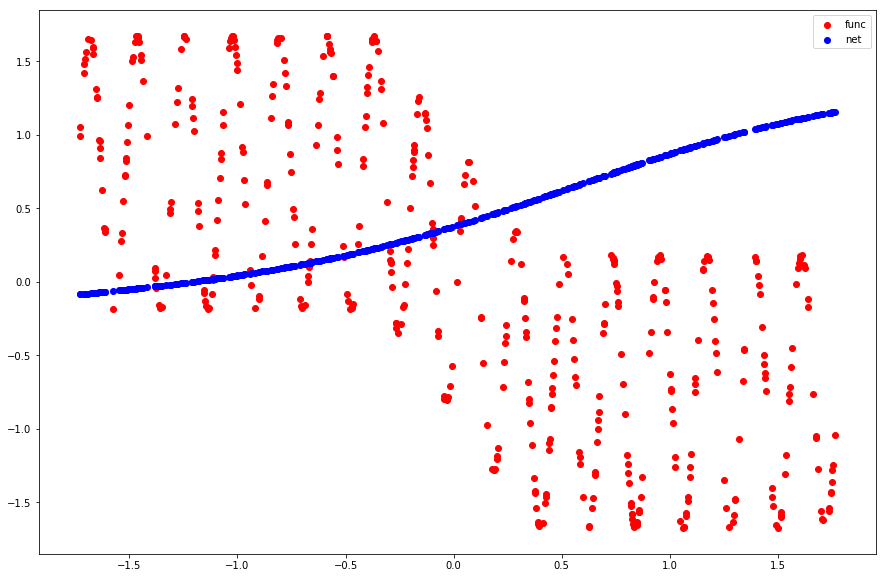

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(learn_data[:, 0], learn_data[:, 1], c='r', label='func')

inputs = autograd.Variable((torch.from_numpy(learn_data[:, 0]).float()).unsqueeze(1))
predict = net.forward(inputs).data.numpy()
plt.scatter(learn_data[:, 0], predict, c='b', label='net')
plt.legend()
plt.savefig('before_training.png', bbox_inches='tight')

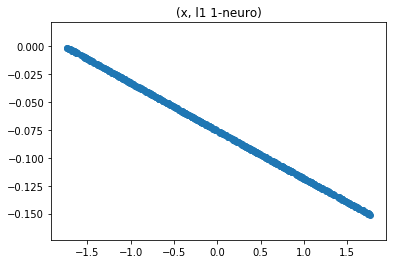

In [16]:
y_exit_l1 = np.tanh(float(net.lin1.weight.data[1, 0])*learn_data[:, 0] + float(net.lin1.bias.data[1]))
plt.scatter(learn_data[:, 0], y_exit_l1)
plt.title('(x, l1 1-neuro)')
plt.savefig('y11_before.png', bbox_inches='tight')

In [60]:
criterion = nn.MSELoss(size_average=True)
optimizer = optim.SGD(net.parameters(), lr=0.1)

In [61]:
l1w = []
l2w = []
l1b = []
l2b = []
num_epoh = []
loss_epoh = []
valid_loss_epoh = []
test_loss_epoh = []
for epoh in range(100000):
    loss_acc = 0
    for mini_batch in dataloader:
        optimizer.zero_grad()
        
        learn_inputs = autograd.Variable(mini_batch[:, 0].float()).unsqueeze(1)
        learn_labels = autograd.Variable(mini_batch[:, 1].float()).unsqueeze(1)
        
        learn_output = net(learn_inputs)
        loss = criterion(learn_output, learn_labels)
        loss.backward()
        optimizer.step()
        loss_acc += float(loss.data)
    loss_epoh.append(loss_acc / (len(dataloader)/50))
    
    if epoh % 1000 == 0:
        num_epoh.append(epoh)
        valid_inputs = autograd.Variable(torch.from_numpy(valid_data[:, 0]).float()).unsqueeze(1)
        valid_labels = autograd.Variable(torch.from_numpy(valid_data[:, 1]).float()).unsqueeze(1)
        test_inputs = autograd.Variable(torch.from_numpy(test_data[:, 0]).float()).unsqueeze(1)
        test_labels = autograd.Variable(torch.from_numpy(test_data[:, 1]).float()).unsqueeze(1)
        valid_output = net(valid_inputs)
        valid_loss = criterion(valid_output, valid_labels)
        test_output = net(test_inputs)
        test_loss = criterion(test_output, test_labels)
        valid_loss_epoh.append(float(valid_loss.data))
        test_loss_epoh.append(float(test_loss.data))
        for num, i in enumerate(net.parameters()):
            if num == 0:
                l1w.append(np.copy(i.data.numpy()))
            if num == 1:
                l2w.append(np.copy(i.data.numpy()))
            if num == 2:
                l1b.append(np.copy(i.data.numpy()))
            if num == 3:
                l2b.append(np.copy(i.data.numpy()))
    
    if epoh % 1000 == 0:
        print("epoh ", epoh)
        print('learn ', loss_epoh[len(loss_epoh)-1])

epoh  0
learn  20.768385529518127
epoh  1000
learn  20.83778664469719
epoh  2000
learn  20.83613008260727
epoh  3000
learn  20.83428516983986
epoh  4000
learn  20.8322311937809
epoh  5000
learn  20.829957276582718
epoh  6000
learn  20.827411115169525
epoh  7000
learn  20.82455262541771
epoh  8000
learn  20.821297764778137
epoh  9000
learn  20.817543864250183
epoh  10000
learn  20.813159346580505
epoh  11000
learn  20.807988196611404
epoh  12000
learn  20.80184295773506
epoh  13000
learn  20.7945154607296
epoh  14000
learn  20.785813629627228
epoh  15000
learn  20.775601416826248
epoh  16000
learn  20.7638156414032
epoh  17000
learn  20.750546604394913
epoh  18000
learn  20.73602870106697
epoh  19000
learn  20.72068527340889
epoh  20000
learn  20.70504292845726
epoh  21000
learn  20.68967267870903
epoh  22000
learn  20.675095468759537
epoh  23000
learn  20.66169500350952
epoh  24000
learn  20.649714171886444
epoh  25000
learn  20.63920333981514
epoh  26000
learn  20.63007354736328
epoh 

In [62]:
l1w = np.array(l1w)
l2w = np.array(l2w)
l1b = np.array(l1b)
l2b = np.array(l2b)
l2b.shape

(100, 1)

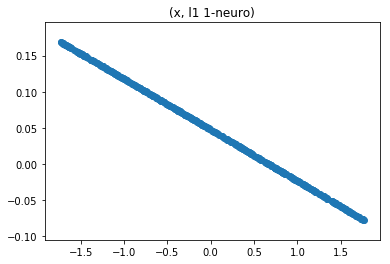

In [63]:
y_exit_l1 = np.tanh(float(net.lin1.weight.data[1, 0])*learn_data[:, 0] + float(net.lin1.bias.data[1]))
plt.scatter(learn_data[:, 0], y_exit_l1)
plt.title('(x, l1 1-neuro)')
plt.savefig('y11_after.png', bbox_inches='tight')

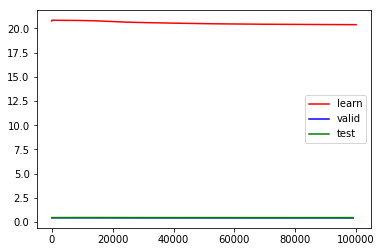

In [64]:
plt.plot(loss_epoh, color='r', label = 'learn')
plt.plot(num_epoh, valid_loss_epoh, color='b', label = 'valid')
plt.plot(num_epoh, test_loss_epoh, color='g', label = 'test')
plt.legend()
plt.savefig('train_valid_test_continue.png', bbox_inches='tight')

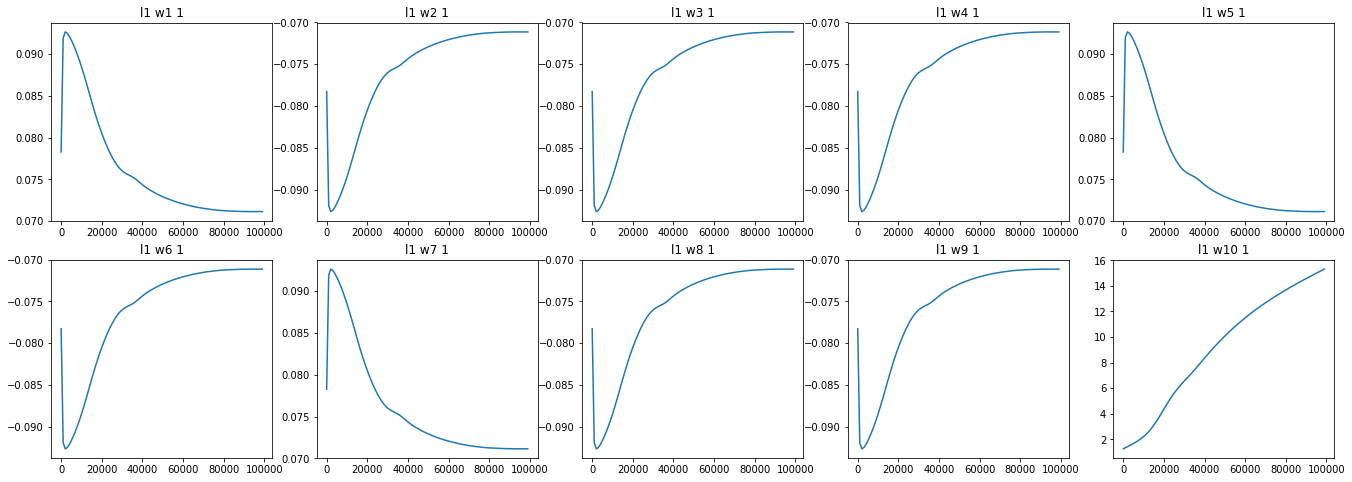

In [65]:
plt.figure(figsize=(23,8))
for i in range(10):
    plt.subplot(2, 5, 1 + i )
    plt.plot(num_epoh, l1w[:, i, 0])
    plt.title('l1 w' + str(i+1)+' 1')
plt.savefig('l1w.png', bbox_inches='tight')

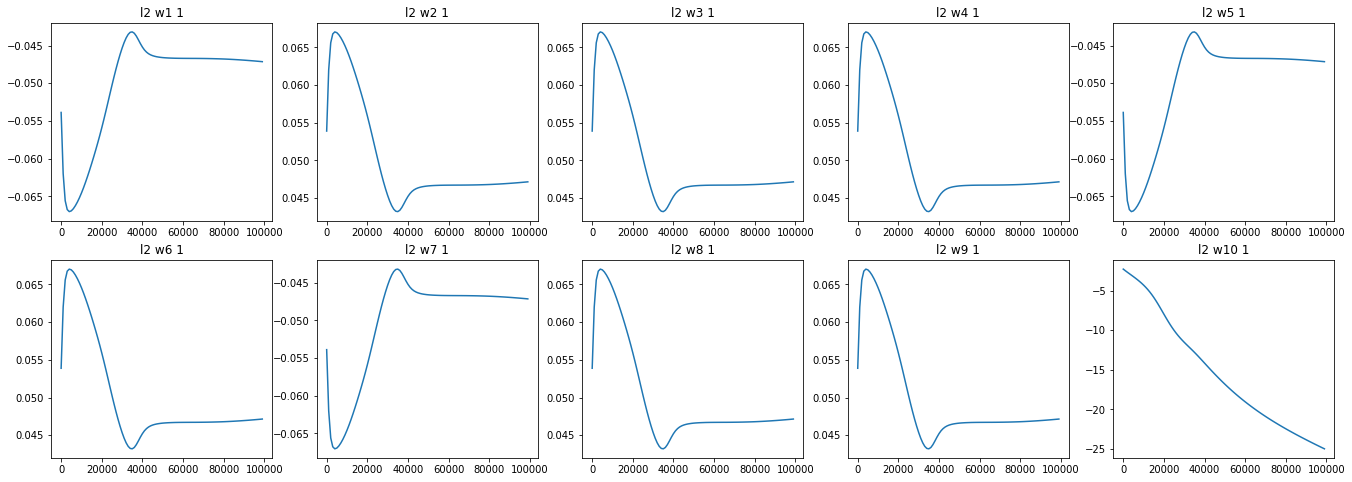

In [66]:
plt.figure(figsize=(23,8))
for i in range(10):
    plt.subplot(2, 5, 1 + i )
    plt.plot(num_epoh, l2w[:, i])
    plt.title('l2 w' + str(i+1)+' 1')
plt.savefig('l2w.png', bbox_inches='tight')

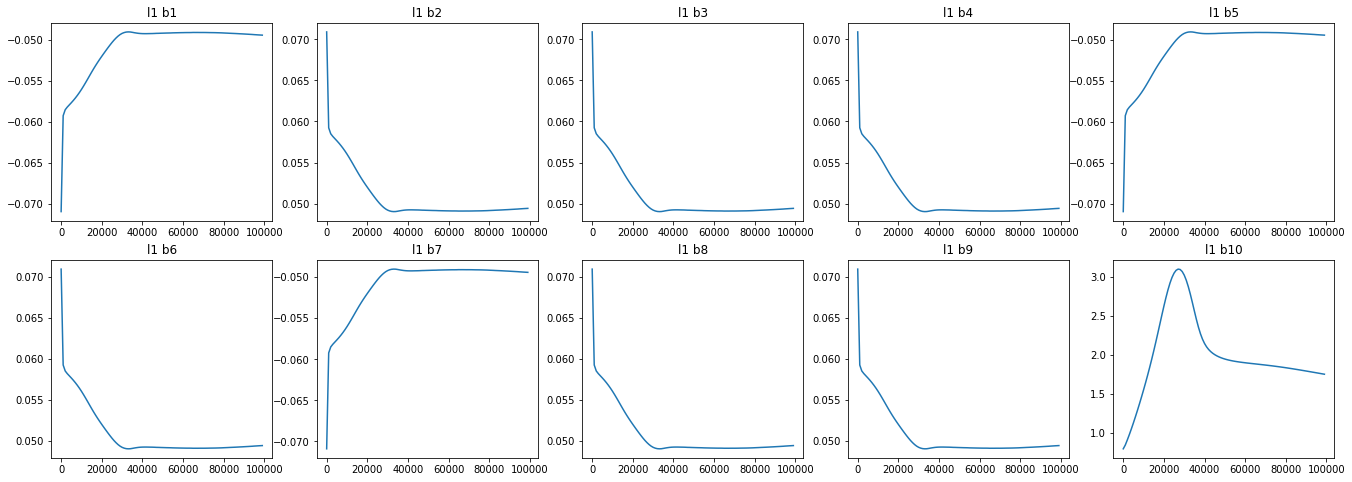

In [67]:
plt.figure(figsize=(23,8))
for i in range(10):
    plt.subplot(2, 5, 1 + i )
    plt.plot(num_epoh, l1b[:, 0, i])
    plt.title('l1 b' + str(i+1))
plt.savefig('l1b.png', bbox_inches='tight')

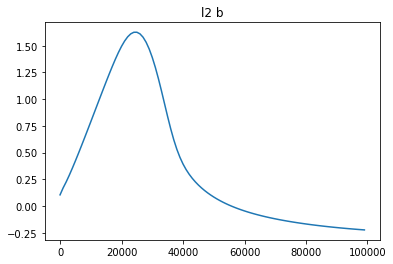

In [68]:
plt.plot(num_epoh, l2b[:, 0])
plt.title('l2 b')
plt.savefig('l2b.png', bbox_inches='tight')

In [69]:
print("learn:")
print(max(loss_epoh))
print(math.sqrt(np.var(loss_epoh)))
print(math.sqrt(np.mean(loss_epoh)))

print("valid:")
print(max(valid_loss_epoh))
print(math.sqrt(np.var(valid_loss_epoh)))
print(math.sqrt(np.mean(valid_loss_epoh)))

print("test:")
print(max(test_loss_epoh))
print(math.sqrt(np.var(test_loss_epoh)))
print(math.sqrt(np.mean(test_loss_epoh)))

learn:
20.840765833854675
0.14931411953557783
4.532625914818203
valid:
0.44784119725227356
0.0036686999765469324
0.66311070706337
test:
0.475104957818985
0.0024417187145538044
0.6856332658201632


[-1.4216032] [0.8986492]


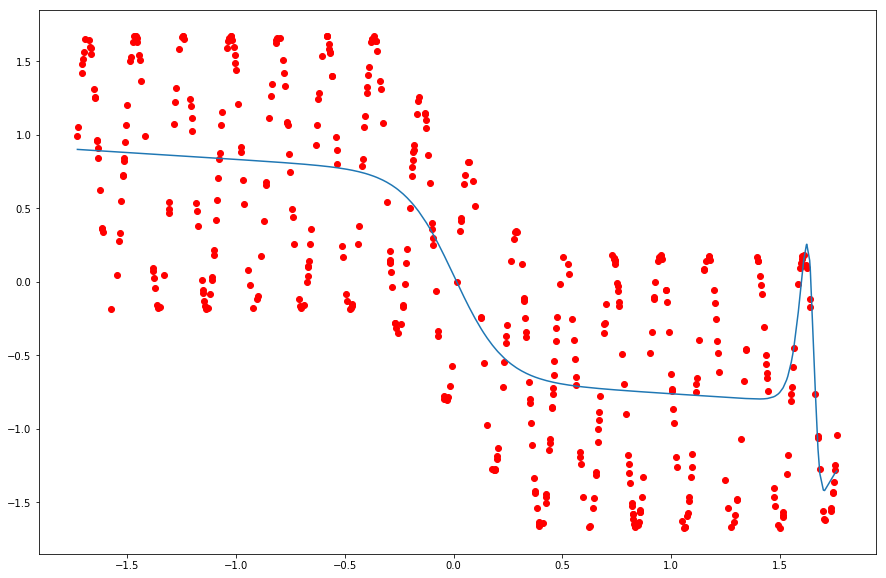

In [70]:
df_buf = pd.DataFrame(dataset.data)
df_buf = df_buf.sort_values(by=0)

x = autograd.Variable((torch.from_numpy(df_buf.get_values()[:, 0]).float()).unsqueeze(1))
y = net.forward(x)
x = x.data.numpy()
y = y.data.numpy()
print(min(y), max(y))
plt.figure(figsize=(15,10))
plt.scatter(learn_data[:,0], learn_data[:,1], color='r')
plt.plot(x, y)
plt.savefig('learndot.png', bbox_inches='tight')